In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, rc
from astropy import cosmology, units, constants

import make_universe_2D #this makes 2Dslices
import make_universe_3D # this makes 3D cubes
import make_universe_3D_old # this makes 3D cubes

import pspec_3D # computes pspecs of 3D cubes 
import pspec_2D # comptues pspecs of 2D slices 


%load_ext autoreload
%autoreload 2

In [3]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize']=16
plt.rcParams['xtick.labelsize']=16

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'STIXGeneral:italic'
plt.rcParams['mathtext.bf'] = 'STIXGeneral:italic:bold'
plt.rcParams['mathtext.rm'] = 'STIXGeneral'

In [4]:
cos = cosmology.Planck18

In [3]:
_map = np.arange(1,100,0.5)

Unit("m3")

In [7]:
beam_sigma = 50*units.arcsec
beam_area = 2*np.pi*(beam_sigma)**2
freq = 5*units.GHz
equiv = units.brightness_temperature(freq)
I = (1*units.Jy/beam_area)
(1*units.Jy/beam_area).to(units.K, equivalencies=equiv)  

<Quantity 3.52629392 K>

In [8]:
if I.unit == 'Jy / arcmin2' or 'Jy / arcsec2': 
    print(I.unit)

Jy / arcsec2


In [35]:
# 21cm rest-frame frequency
nu0 = 1420e6 * units.Hz

## Parameters

In [36]:
# specs
ang_res = 16.*units.arcsec # angular resolution
#number of pixels in row and col (ang res)
npix = 101
#length and width of the box in Mpc
L = 1.47e3

In [37]:
# full bandwidth
fmin, fmax = 106e6 * units.Hz, 196e6 * units.Hz
df = 100e3 * units.Hz
bandwidth = np.arange(fmin.value, fmax.value + df.value, step=df.value)

# spectral window
avg_nu = 150.e6 * units.Hz
avg_z = nu0/avg_nu-1
avg_lamb = constants.c.si / avg_nu.si

nfreqs = 150
iavg = list(bandwidth).index(avg_nu.value)

spw_range = (iavg-150//2, iavg+150//2)
spw_window = bandwidth[spw_range[0]:spw_range[1]] * units.Hz
z_array = nu0/spw_window-1.

print(f'{spw_window.size} frequency channels, '\
      f'mean frequency {spw_window.mean().value/1e6:.1f} MHz, '\
      f'mean redshift {np.mean(z_array):.1f}.')

150 frequency channels, mean frequency 149.9 MHz, mean redshift 8.5.


In [38]:
## I don't think there should be a factor of 2 in the denominator here... 

kmin = 2.*np.pi/L*2.
kmax = 2.*np.pi*npix/L/2.
print(kmin, kmax)

0.008548551438339573 0.21585092381807422


## Generate cosmological random field

We generate a cosmological signal with a constant power spectrum $P(k)= A_0$ where $A_0 = 10\,\mathrm{mK}^2$. To obtain a constant spectrum across frequencies, we use:
\begin{equation}
P(k) = X(z)^2 Y(z)\, \delta \Omega\, \delta \nu\, \delta T_b(z)^2,
\end{equation}
where we adjust $\delta T_b(z)$ at each frequency. Here, $\delta \Omega$ is the angular resolution in steradian and $\delta \nu$ is the frequency resolution in Hz. We have
\begin{aligned}
X(z) &= \frac{c(1+z)^2}{\nu_{21} H(z)},\\
Y(z) &= D(z),
\end{aligned}
where $D(z)$ is the transverse comoving distance and $\nu_{21}$ the rest-frame $21\,\mathrm{cm}$ frequency.

In [309]:
def X(z):
    return constants.c.si * (1.+z)**2 / nu0.si / cos.H(z).si
def Y(z):
    return cos.comoving_distance(z).si

In [310]:
def flat_ps(k, amp=100):
    """
    Generate a flat power spectrum of amplitude amp.

    Parameters
    ----------
        k: float or array of flats
            Fourier mode in Mpc-1.
        amp: float
            Desired amplitude for the PS, in K2.

    """
    k = np.atleast_1d(k)
    return 100 * np.ones(k.shape)


Text(0.5, 0, '$k$ [Mpc$^{-1}$]')

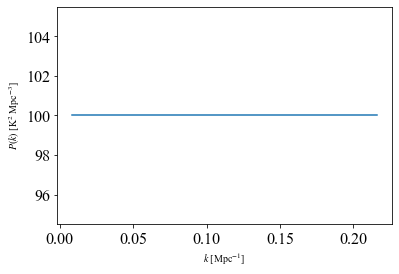

In [311]:
# amp = 100 # mK2

krange = np.linspace(kmin, kmax, 100)

plt.figure()
plt.plot(krange, flat_ps(krange))
plt.ylabel(r"$P(k)$ [K$^2$ Mpc$^{-3}$]")
plt.xlabel(r"$k$ [Mpc$^{-1}$]")


In [312]:
make_uni = make_universe_2D.universe(
    flat_ps,
    npix, npix,
    L, L,
    mean = None)
uni = make_uni.make_2D_universe()


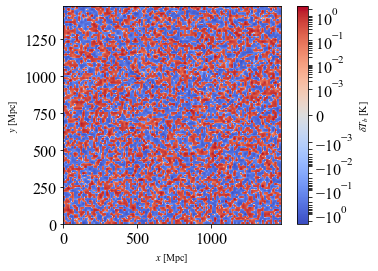

In [313]:
plt.figure()
plt.imshow(uni, origin='lower',
           extent=(0, L, 0, L),
           cmap='coolwarm',
           norm=colors.SymLogNorm(1e-3))
plt.xlabel(r'$x$ [Mpc]')
plt.ylabel(r'$y$ [Mpc]')
plt.colorbar(label=r'$\delta T_b$ [K]')

In [314]:
np.var(uni)

0.4667399223771694

In [315]:
# now you can compute the pspec of this field to make sure
# that you get out what you put in 

pspec_2d = pspec_2D.Power_Spectrum(
    data=uni,
    Lx=L,
    Ly=L,
    nbins=15,
    kmax=kmax)

k, pspec = pspec_2d.compute_pspec()

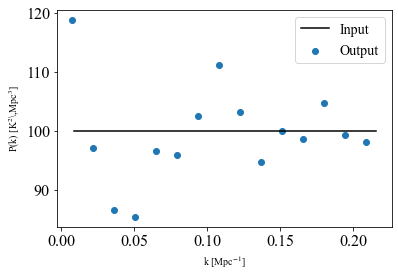

In [316]:
plt.figure()
plt.plot(krange,
         flat_ps(krange),
         label='Input',
         color='k')
plt.scatter(k, pspec, label='Output',
            marker='o', color='C0')
plt.ylabel(r"P(k) [K$^2$\,Mpc$^3$]")
plt.xlabel(r"k [Mpc$^{-1}$]")
plt.legend(fontsize = 14)
# plt.xlim(0,0.1)

# Make 3D Gaussian random field

To obtain the comoving length $L$ in the $z$ direction, we use
\begin{equation}
L= \frac{c \sqrt{1+z}}{H_0 \nu_0 \sqrt{\Omega_{\mathrm{m}}}}  \Delta \nu
\end{equation}
for $\Delta \nu$ the bandwidth in Hz.

In [317]:
theta_x = ang_res * npix

Dnu = (spw_window.max() - spw_window.min())
Lz = (constants.c.si * np.sqrt(1.+avg_z.value) / cos.H0.si / nu0.si / np.sqrt(cos.Om0) * Dnu.si).to(units.Mpc)
print(L, Lz)


#number of k bins
nbins = 30

1470.0 257.0648052497096 Mpc


In [335]:
np.random.seed(0)

#make a lil universe
uni_3d = make_universe_3D.universe(
    flat_ps,
    npix,
    npix,
    nfreqs, 

    L,
    L,
    Lz.value,
    nbins,
    z_mid=avg_z.value,
    verbose=True)

In [336]:
uni = uni_3d.make_universe()

Getting k box...
Generating fft box
Taking iFFT of box
mean 7.7780549776046e-20


In [337]:
#make a lil universe
uni_3d_old= make_universe_3D_old.universe(
    flat_ps,
    npix,
    npix,
    nfreqs, 
    L,
    L,
    Lz.value,
    nbins,
    z_mid=avg_z.value)

uni_old = uni_3d_old.make_universe()

1470.0 1470.0 257.0648052497096


In [343]:
np.var(uni_3d_old.universe)

0.2754751533415167

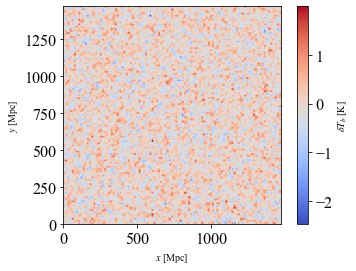

In [344]:
#Let's see a random freq slice 
plt.figure()
plt.imshow(uni_3d_old.universe[:, :, 43],
           origin='lower',
           extent=(0, L, 0, L),
           cmap='coolwarm')
           
        #    norm=colors.SymLogNorm(1e-6)
plt.xlabel(r'$x$ [Mpc]')
plt.ylabel(r'$y$ [Mpc]')
plt.colorbar(label=r'$\delta T_b$ [K]')

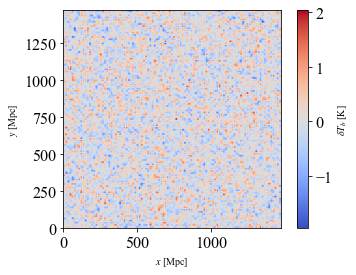

In [340]:
#Let's see a random freq slice 
plt.figure()
plt.imshow(uni[:, :, 43],
           origin='lower',
           extent=(0, L, 0, L),
           cmap='coolwarm')
           
        #    norm=colors.SymLogNorm(1e-6)
plt.xlabel(r'$x$ [Mpc]')
plt.ylabel(r'$y$ [Mpc]')
plt.colorbar(label=r'$\delta T_b$ [K]')

In [341]:
np.var(uni)

0.2730409222051752

In [345]:
''' Compute 1d pspec of the cube. You can do this either by binning your Fourier cube in spherical shells directly
or, you can compute the 2D power spectrum and then bin in quarter annuli.
please keep in mind that the resulting power spectra will be slightly different due to the kperp binning step'''

pspec_3d = pspec_3D.Power_Spectrum(
    data=uni, 
    theta_x=theta_x.to(units.rad).value,
    theta_y=theta_x.to(units.rad).value,
    freqs=spw_window.to(units.MHz).value,
    rest_freq=nu0.to(units.MHz).value,
    # nbins=30,
    # nbins_perp=60,
    verbose=True)
pspec_3d.compute_volume()
ps_data = pspec_3d.cosmo_FFT3()

Taking FT of data...


In [346]:
pspec_1d = pspec_3d.compute_1D_pspec(ps_data=ps_data)


Binning data...


In [347]:
pspec1d_from_2d = pspec_3d.compute_1d_from_2d(ps_data=ps_data)

Binning data...


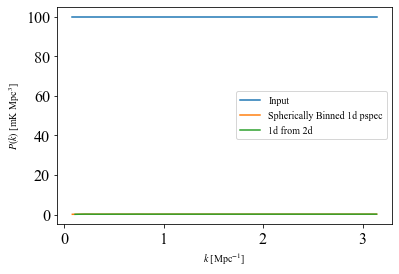

In [348]:
plt.figure()
plt.plot(pspec_1d[0], flat_ps(pspec_1d[0]), label = 'Input')
plt.plot(pspec_1d[0], pspec_1d[1], label = 'Spherically Binned 1d pspec')
plt.plot(pspec1d_from_2d[0], pspec1d_from_2d[1], label = '1d from 2d')
plt.ylabel(r"$P(k)$ [mK Mpc$^3$]")
plt.xlabel(r"$k$ [Mpc$^{-1}$]")
plt.legend(loc = 'best')
# plt.xlim(0,0.15)
# plt.ylim(-1,11)

In [349]:
#compute 2D pspec 
k_par, k_perp, pspec_2d = pspec_3d.compute_2D_pspec(ps_data=ps_data)

Binning data...


Text(0.5, 0, 'k$_\\perp$[Mpc$^{-1}]$')

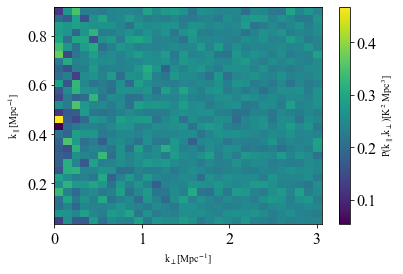

In [350]:
im = plt.pcolor(k_perp,
                k_par,
                pspec_2d,
                # norm=colors.LogNorm(),
                shading='auto')#, edgecolors='w', linewidth=0.5)
plt.colorbar(label = 'P(k$_\parallel$,k$_{\perp}$)[K$^2$ Mpc$^3$]') #worried about the scale, i think here you only need to divide by the 2d vol you're averaging over not the entire 3D vol. 
plt.ylabel('k$_\parallel$[Mpc$^{-1}]$')
plt.xlabel('k$_\perp$[Mpc$^{-1}]$')

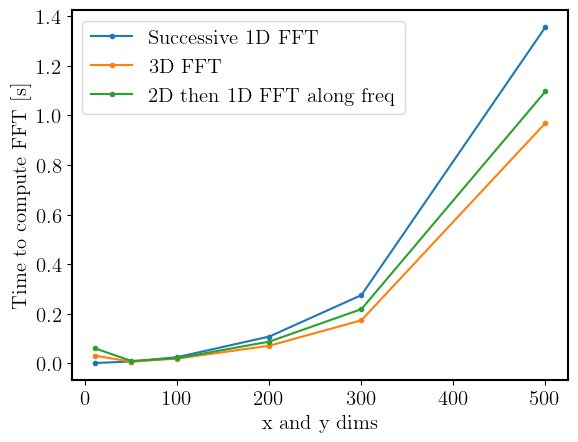

In [84]:
import time
dims = np.array([10, 50, 100, 200, 300, 500])
times1, times2, times3 = np.zeros(dims.size), np.zeros(dims.size), np.zeros(dims.size)
for u, nn in enumerate(dims):

    cube = pspec_3d.data[:nn, :nn, :]
    test1 = np.array(cube, dtype=complex)
    t0 = time.perf_counter()
    for i in range(cube.ndim):
        test1[...] = np.fft.fft(test1, axis=i)
    t1 = time.perf_counter()
    times1[u] = t1-t0

    cube = pspec_3d.data[:nn, :nn, :]
    t0 = time.perf_counter()
    test2 = np.fft.fftn(cube)
    t1 = time.perf_counter()
    times2[u] = t1-t0

    t0 = time.perf_counter()
    test3 = np.fft.fft2(cube, axes=(0, 1))
    test4 = np.fft.fft(test3, axis=2)
    t1 = time.perf_counter()
    times3[u] = t1-t0

plt.figure()
plt.plot(dims, times1, label='Successive 1D FFT', marker='.')
plt.plot(dims, times2, label='3D FFT', marker='.')
plt.plot(dims, times3, label='2D then 1D FFT along freq', marker='.')
plt.xlabel('x and y dims')
plt.ylabel('Time to compute FFT [s]')
plt.legend()


In [85]:
import time
dims_pow2 = np.array([2**i for i in np.arange(4, 10)])
times1_pow2, times2_pow2, times3_pow2 = np.zeros(dims.size), np.zeros(dims.size), np.zeros(dims.size)
for u, nn in enumerate(dims):

    cube = pspec_3d.data[:nn, :nn, :]
    test1 = np.array(cube, dtype=complex)
    t0 = time.perf_counter()
    for i in range(cube.ndim):
        test1[...] = np.fft.fft(test1, axis=i)
    t1 = time.perf_counter()
    times1_pow2[u] = t1-t0

    cube = pspec_3d.data[:nn, :nn, :]
    t0 = time.perf_counter()
    test2 = np.fft.fftn(cube)
    t1 = time.perf_counter()
    times2_pow2[u] = t1-t0

    t0 = time.perf_counter()
    test3 = np.fft.fft2(cube, axes=(0, 1))
    test4 = np.fft.fft(test3, axis=2)
    t1 = time.perf_counter()
    times3_pow2[u] = t1-t0


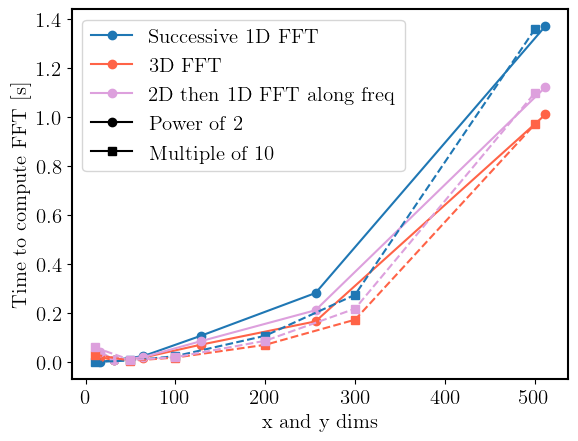

In [86]:
plt.figure()
plt.plot(dims_pow2, times1_pow2, label='Successive 1D FFT', marker='o', color='C0')
plt.plot(dims_pow2, times2_pow2, label='3D FFT', marker='o', color='tomato')
plt.plot(dims_pow2, times3_pow2, label='2D then 1D FFT along freq', marker='o', color='plum')
plt.plot(dims, times1, marker='s', color='C0', ls='--')
plt.plot(dims, times2, marker='s', color='tomato', ls='--')
plt.plot(dims, times3, marker='s', color='plum', ls='--')
plt.plot([], [], marker='o', color='k', label='Power of 2')
plt.plot([], [], marker='s', color='k', label='Multiple of 10')
plt.xlabel('x and y dims')
plt.ylabel('Time to compute FFT [s]')
plt.legend()

In [38]:
for array_length in (2**22, (2**22)-1):
    total_time = 0

    # Do the FFT 10 times, to allow for some random error
    for i in range(10):
        in_array = np.random.rand(array_length)
        start = time.perf_counter()
        out_array = np.fft.fft(in_array)
        total_time += time.perf_counter() - start

    print("array_length:", array_length,
          "total_time:", total_time)

array_length: 4194304 total_time: 1.1327115429994592
array_length: 4194303 total_time: 7.582052458000362


In [54]:
array_length = 2**22

total_time = 0
in_array = np.random.rand(array_length)
start = time.perf_counter()
out_array = np.fft.fft(in_array)
total_time += time.perf_counter() - start

print("fft:", array_length,
        "total_time:", total_time)

total_time = 0
in_array = np.random.rand(array_length)
start = time.perf_counter()
out_array = np.fft.rfft(in_array)
total_time += time.perf_counter() - start

print("rfft:", array_length,
        "total_time:", total_time)
print(in_array.shape, out_array.shape)

fft: 4194304 total_time: 0.10686029199996483
rfft: 4194304 total_time: 0.05931329199984248
(4194304,) (2097153,)


In [55]:
import pyfftw

In [56]:
def np_rfft(*args):
    return np.fft.rfft(*args)

def interfaces_rfft(*args):
    return pyfftw.interfaces.numpy_fft.rfft(*args)

# Use our wrapper functions else function names will be "rfft" for both
for fft_func in (np_rfft, interfaces_rfft):

    for array_length in (2**22, (2**22)-1):
        total_time = 0

        for i in range(10):
            in_array = np.random.rand(array_length)
            start = time.perf_counter()
            out_array = fft_func(in_array)
            total_time += time.perf_counter() - start

        print("fft_func:", fft_func.__name__,
              "array_length:", array_length,
              "total_time:", total_time)


fft_func: np_rfft array_length: 4194304 total_time: 0.5617553730012332
fft_func: np_rfft array_length: 4194303 total_time: 3.6743668329991124
fft_func: interfaces_rfft array_length: 4194304 total_time: 1.263076332001674
fft_func: interfaces_rfft array_length: 4194303 total_time: 2.741399707999335


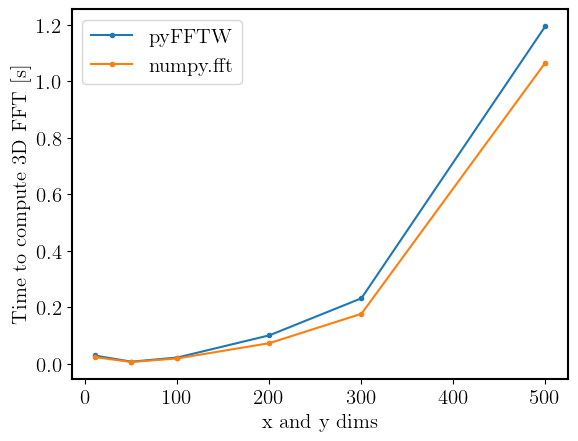

In [87]:
dims = np.array([10, 50, 100, 200, 300, 500])
times1, times2 = np.zeros(dims.size), np.zeros(dims.size)
for u, nn in enumerate(dims):
    cube = pspec_3d.data[:nn, :nn, :]

    t0 = time.perf_counter()
    test = pyfftw.interfaces.numpy_fft.fftn(cube)
    t1 = time.perf_counter()
    times1[u] = t1-t0

    t0 = time.perf_counter()
    test2 = np.fft.fftn(cube)
    t1 = time.perf_counter()
    times2[u] = t1-t0

plt.figure()
plt.plot(dims, times1, label='pyFFTW', marker='.')
plt.plot(dims, times2, label='numpy.fft', marker='.')
plt.xlabel('x and y dims')
plt.ylabel('Time to compute 3D FFT [s]')
plt.legend()


Text(0, 0.5, 'Diff time w and w\\o FFT shift [s]')

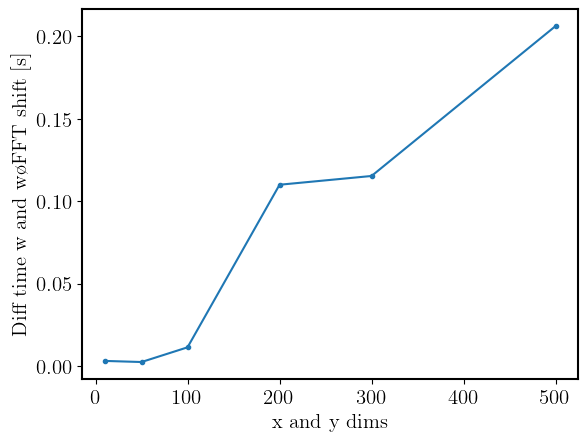

In [26]:
plt.figure()
plt.plot(dims, times1-times2, marker='.')
plt.xlabel('x and y dims')
plt.ylabel('Diff time w and w\o FFT shift [s]')